10.0%. Run time:  47.31s. Est. time left: 00:00:07:04
20.0%. Run time:  99.88s. Est. time left: 00:00:06:38
30.1%. Run time: 154.50s. Est. time left: 00:00:05:59
40.1%. Run time: 208.32s. Est. time left: 00:00:05:11
50.1%. Run time: 261.76s. Est. time left: 00:00:04:20
60.1%. Run time: 314.51s. Est. time left: 00:00:03:28
70.1%. Run time: 368.76s. Est. time left: 00:00:02:37
80.1%. Run time: 422.88s. Est. time left: 00:00:01:44
90.2%. Run time: 480.70s. Est. time left: 00:00:00:52
100.0%. Run time: 534.15s. Est. time left: 00:00:00:00
Total run time: 534.16s


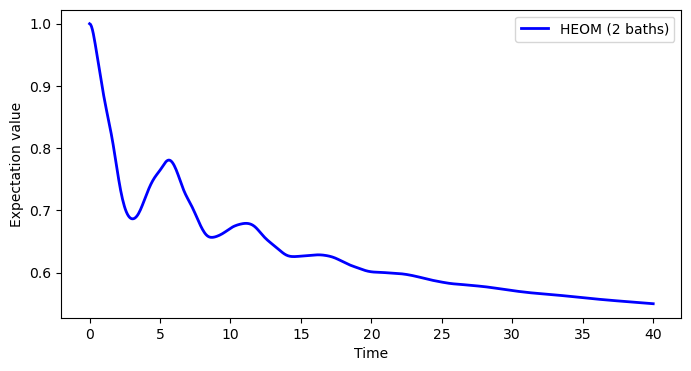

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver

# System parameters
eps, Del = 0.5, 1.0
H_sys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

# Bath parameters
Nk, max_depth = 3, 10
Q = sigmaz()
gam, alpha = 0.05, 2.5 / np.pi
T_vals = [1.0 / 0.95, 1.0 / 0.72]  # Temperatures for two baths

# Create Drude–Lorentz baths
baths = [DrudeLorentzBath(Q, alpha, gam, T, Nk) for T in T_vals]

# Liouvillian for the system Hamiltonian
HL = 1j * (spre(H_sys) - spost(H_sys))

# HEOM solver configuration
options = {"nsteps": 15000}
heom_solver = HEOMSolver(HL, baths, max_depth=max_depth, options=options)

# Initial state
rho0 = basis(2, 1) * basis(2, 1).dag()

# Time evolution
tlist = np.linspace(0, 40, 600)
result = heom_solver.run(rho0, tlist)

# Expectation value computation
observable = 0.5 * (sigmaz() - qeye(2))
exp_vals = np.array([expect(observable, state) for state in result.states])

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(tlist, -np.real(exp_vals), 'b-', linewidth=2, label="HEOM (2 baths)")
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# System parameters
chi = 0.5  # Dissipation strength
Theta0 = 1  # Initial decay rate

# Define c(t)
def c(t, chi):
    delta = chi**2 - 2 * Theta0 * chi
    if delta > 0:
        d = np.sqrt(delta)
        return np.exp(-chi * t / 2) * (np.cosh(d * t / 2) + (chi / d) * np.sinh(d * t / 2))
    elif delta == 0:
        return np.exp(-chi * t / 2) * (1 + (chi * t) / 2)
    else:
        d = np.sqrt(-delta)
        return np.exp(-chi * t / 2) * (np.cos(d * t / 2) + (chi / d) * np.sin(d * t / 2))

# Compute Theta(t) and S(t)
def Theta(t, chi, dt=1e-4, eps=1e-10):
    c_t = c(t, chi)
    c_t_plus_dt = c(t + dt, chi)
    c_dot = (c_t_plus_dt - c_t) / dt
    return -2 * np.real(c_dot / (c_t + eps))  # Avoid division by zero

def S(t, chi, dt=1e-4, eps=1e-10):
    c_t = c(t, chi)
    c_t_plus_dt = c(t + dt, chi)
    c_dot = (c_t_plus_dt - c_t) / dt
    return -2 * np.imag(c_dot / (c_t + eps))  # Take only imaginary part

# Time evolution parameters
tlist = np.linspace(0, 20, 500)

# Define time-dependent Hamiltonian
H_t = [[sigmap() * sigmam(), lambda t, args: S(t, chi)]]

# Define FCS collapse operator
def collapse_op_coeff(t, args):
    Theta_t = Theta(t, chi)
    return np.sqrt(complex(Theta_t))

c_ops = [[sigmam(), collapse_op_coeff]]  # Collapse operator

# Solve for density matrix evolution
rho0 = basis(2, 0) * basis(2, 0).dag()  # Initial state |0⟩⟨0|

# Solve master equation
e_ops = [basis(2, 1) * basis(2, 1).dag(), basis(2, 0) * basis(2, 0).dag()]  # Measure populations
options = {"nsteps": 10000, "atol": 1e-6, "rtol": 1e-6}  # Adaptive solver options
result = mesolve(H_t, rho0, tlist, c_ops, e_ops=e_ops, options=options, args={})

# Extract explicit populations
rho_11 = np.real(np.array(result.expect[0]))  # Population of |1⟩
rho_00 = np.real(np.array(result.expect[1]))  # Population of |0⟩

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(tlist, rho_11, label=r"$\rho_{11}$ (Excited state population)", color='r')
plt.plot(tlist, rho_00, label=r"$\rho_{00}$ (Ground state population)", color='b', linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Time Evolution of Populations")
plt.grid()
plt.show()
